## Import necessary python modules

In [1]:
import os
import napari
import tifffile
import numpy as np
import matplotlib.pyplot as plt

import bigfish
import bigfish.plot as plot
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack

from copy import deepcopy
from dask.array.image import imread as imr
from bigfish.detection.utils import get_object_radius_pixel
from buildReferenceSpot import buildReferenceSpotFromImages
from runBigfishDetection import getSpotAndClusters, saveSpotsNPZ, reorderZstack, getSpotAndClusters_multi

In [2]:
from order_spot import * 

## Specify Input and Output folders, identifiers

In [3]:
homeFolder = '/media/raphael/data/works/20231220_C3_14_2h_ofON/new_correction/'
nameKey = 'C3.14_ON_01_w1SPI-488_s'

imsQ = '4'
cellNumber = '18'
nucleiStackForm = nameKey+imsQ+"_cell_"

pathToTimeSequenceFullView = homeFolder+nameKey+imsQ+'/*.tif'
cell_Crop_Folder = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
pathToTimeSequenceCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'


sequenceCell = imr(pathToTimeSequenceCell)
sequenceCell = sequenceCell
mipSequenceCell = np.max(sequenceCell, axis=1)
MaxTimePoint = sequenceCell.shape[0]

## Specify voxel and object size

In [4]:
voxelRadius = (700, 110, 110) # in nanometers
objectRadius = (700, 105, 105) # in nanometers

In [5]:
alpha = 0.5

beta = 1
gamma = 15

## Choose detection threshold

In [6]:
selectedThreshold = int(input("Enter your selected threshold: "))

Enter your selected threshold: 70


In [7]:
minFrame = int(input("Enter your max Frame: "))
minFrame = minFrame 

Enter your max Frame: 1


In [8]:
maxFrame = int(input("Enter your max Frame: "))
maxFrame = maxFrame + 1 

Enter your max Frame: 120


### Compute list of threshold 

## Get a list of spots detected using the threshold specified in previous step

Voire graphe du notebook 4 bleaching correction

Toutes les frames ne suivent pas la meme allure avec des images bcp moins intense que l'autre d'une frame a l'autre besoin de ponderer le threshold en fonction d'une moyenne generale et d'une liste de moyenne en fonction des frames 

if mean_frame < moy_gen :
    abaisser le threshold
elid mean_frame > moy_gen :
    augmenter le threshold
    
else : 
    conserver threshold 
    
Ou possibilite d'appliquer ce principe a une difference de pourcentage d'une frame a l'autre 

In [9]:
images=[]    
spots_list=[]

spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=voxelRadius, 
    object_radius_nm=objectRadius, 
    ndim=3)

for t in range(minFrame,maxFrame,1):

    path = os.path.join(cell_Crop_Folder, nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif")
    rna = stack.read_image(path)
    images.append(rna)

n=len(images)
print("Total number of images : "+str(n))

selectedThreshold_loop = selectedThreshold

for rna in images:
    try : 
        # LoG filter
        rna_log = stack.log_filter(rna, sigma=spot_radius_px)
    
        # local maximum detection
        mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)
    
        # thresholding
        threshold = detection.automated_threshold_setting(rna_log, mask)
        
        selectedThreshold_loop = (selectedThreshold_loop) #*((100+var_list[i])/100) 
        #print(selectedThreshold_loop)
        spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold_loop))
        spots_list.append(spots_)
    except IndexError as e: 
        spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold))
        spots_list.append(spots_)
        print('Done')
        break 

Total number of images : 120


## Build reference spot

image list found!
Found 11044
Found 11044 spots, max intensity = 229


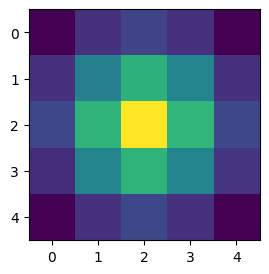

In [10]:
reference_spot = buildReferenceSpotFromImages(images, spots_list, alpha=alpha, gamma=5, voxelSize=voxelRadius, objectSize=objectRadius)
%matplotlib inline
plt.figure(num=3,figsize=(3,3))
plt.imshow(np.max(reference_spot, axis=0))
refSpot = deepcopy(reference_spot)

## Perform spot and cluster detection for all frames

comparer detection avec beta = 1 gamma = 10 et beta = 2 gamma = 20 

In [11]:
spotsFrame, clustersFrames, ThresholdFrames = getSpotAndClusters(images, 
                                                                 reference_spot, 
                                                                 cellnumber=cellNumber, 
                                                                 startTime=minFrame-1,
                                                                 stopTime=maxFrame-1,
                                                                 thresholdManual=selectedThreshold, 
                                                                 beta=beta, #2
                                                                 gamma=gamma, #15 
                                                                 numberOfSpots=2,
                                                                 radiusCluster=400, 
                                                                 voxelSize=voxelRadius, 
                                                                 objectSize=objectRadius,
                                                                 extensionMov='.tif')

0
1
2
3
4
5


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


6
7
8


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


9


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


10


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


11


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


12


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


13


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


14


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


15


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


16


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


17


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


18
19


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


20


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


21
22
23


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


24


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


25
26
27


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


28
29


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


30


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


31
32


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


33


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


34


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


35


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


36
37
38
39
40
41
42


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/dense_decomposition_live.py:264: UserWarning: Problem occurs during the decomposition of dense regions. Less spots are detected after the decomposition than before.
  warnings.warn("Problem occurs during the decomposition of dense "


99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
done!


In [12]:
a = sort_clustersFrames(clustersFrames,mipSequenceCell,400,perc=1)

on 46: 46 [] [[458]]                                                            
on 46: max() arg is an empty sequence                                           
sort cluster frame |████████████████████████████████████████| 120/120 [100%] in 


## Correct clusters position if needed 

a[X] = move_sorted_clustersFrames(a[X], [z,y,x,n,i], new_position=int)

In [13]:
# a[2] = move_sorted_clustersFrames(a[2], np.array([ 7, 81, 63,  3,  2]), 0)

## Merge clusters 

In [13]:
b = merge_clusters_frame(a,diff=4)

In [14]:
c = create_index2(b)    

In [15]:
c

[[array([ 8, 89, 64,  6,  0])],
 [array([32, 79, 81,  3,  1])],
 [array([ 15, 109,  81,   2,   2])],
 [array([ 0, 82, 74,  3,  3])],
 [array([24, 93, 83,  2,  4])],
 [array([ 14, 104, 112,   4,   5])],
 [array([ 25, 109,  84,   4,   6])],
 [array([ 10, 121, 110,   3,   7])],
 [array([ 28, 109,  76,   4,   8])],
 [array([ 18, 102,  88,   5,   9])],
 [array([ 22, 108,  87,   5,  10])],
 [array([ 17, 103, 102,   8,  11])],
 [array([  8, 116, 112,   8,  12])],
 [array([  5, 114, 107,   4,  13])],
 [array([ 17, 100,  97,   6,  14])],
 [array([ 24, 101, 100,   6,  15])],
 [array([23, 93, 97,  6, 16])],
 [array([ 16,  84, 100,   5,  17])],
 [array([ 34,  85, 116,   4,  18])],
 [array([15, 92, 91,  5, 19])],
 [array([ 17,  77, 101,   6,  20])],
 [array([ 30,  73, 120,   3,  21])],
 [array([ 24,  76, 136,   5,  22])],
 [array([ 20,  83, 126,   6,  23])],
 [array([  9,  75, 127,   6,  24])],
 [array([ 14,  84, 130,   6,  25])],
 [array([ 35,  71, 110,   4,  26])],
 [array([ 23,  69, 116,   6,  2

In [22]:
a[20]

[array([ 17,  77, 101,   6,   1]),
 array([ 12, 107, 110,   2,   2]),
 array([ 13,  85, 109,   2,   3]),
 array([ 14,  78, 132,   2,   5]),
 array([ 15,  92, 121,   2,   6]),
 array([ 14,  95, 103,   2,   4]),
 array([ 11,  99, 107,   2,   0]),
 array([ 16,  61, 107,   2,   7])]

In [18]:
def get_all_clusters(images,threshold,size):
    '''
    This function return a list of array corresponding to all the pixel corresponding to the most intense regions of a cell 
    '''
    res=[]
    i = 0
    for frames in images : 
        tmp = np.where(frames>threshold)
        coord = []
        for px in range(0,len(tmp[0])):
            z = tmp[0][px]
            y = tmp[1][px]
            x = tmp[2][px]
            if len(coord) < size : 
                coord.append([z,y,x,i])
        res.append(coord)
        i = i+1 
    return res 

In [19]:
ttest = get_all_clusters(images,400,50)

## Save detection results to be used later

In [17]:
saveSpotsNPZ(np.array(spotsFrame, dtype=object), 
             np.array(clustersFrames, dtype=object), 
             np.array(ThresholdFrames, dtype=object), 
             cellNumber, 
             cell_Crop_Folder, 
             reference_spot,
             threshold = selectedThreshold
             ) 


## Visualise detection results

In [18]:
def getDetectedPointsForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-1])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:]
    return pts_coords

def getDetectedClustersForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-3])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:3]
    return pts_coords

def set_pts_features(pts_layer, cls_layer, pts_coordinates, cluster_coordinate, step): #TxLayer
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
    pts_layer.data = getDetectedPointsForFrame(pts_coordinates,frameNumber)
    cls_layer.data = getDetectedClustersForFrame(cluster_coordinate,frameNumber)


pts_coordinates = spotsFrame
cluster_coordinate = c

viewer = napari.Viewer()
image_layer = viewer.add_image(
        mipSequenceCell, colormap='green' #maxImageCell
        )
if image_layer.data.ndim == 4:
    bigfishSpots = spotsFrame
elif image_layer.data.ndim == 3:
    bigfishSpots = getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2))
    
bigfish_Spots = viewer.add_points(
        getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=4,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='white',
        name = 'bigFish Detected Spots'
        )

bigfish_clusters = viewer.add_points(
        getDetectedClustersForFrame(cluster_coordinate,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        symbol='diamond',
        name = 'bigFish Clusters'
        )


viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_Spots, bigfish_clusters, pts_coordinates, cluster_coordinate, event.value)
        )



<function __main__.<lambda>(event)>

# Save clusters frame in csv 

In [19]:
b = np.concatenate(c)
savepath = homeFolder+nameKey+imsQ + '/' + nameKey + imsQ + '_TS' +'_cell_' + cellNumber + '_fusion_'+  str(alpha) +'_' + str(beta) + '_' + str(gamma) + '_thres_' + str(selectedThreshold) + '.csv'

In [20]:
entete = ['z','y','x','n_molecule','index']

In [21]:
import csv 

with open(savepath, 'w', newline='') as csv_file :
    writer = csv.writer(csv_file)
    writer.writerow(entete)
    writer.writerows(b)

In [25]:
import session_info
session_info.show()